## Data Preprocssing

In [ ]:
import zipfile
import pandas as pd

def extract_csv_from_zip(zip_file_path, columns_to_load=None):
    """
    Extracts a CSV file from a ZIP archive and loads it into a pandas DataFrame.
    """
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            print(f"Files in ZIP: {file_list}")

            csv_file_name = next((file for file in file_list if file.endswith('.csv')), None)

            if csv_file_name:
                with zip_ref.open(csv_file_name) as csv_file:
                    df = pd.read_csv(csv_file, usecols=columns_to_load)
                    print("CSV content successfully loaded.")
                    return df
            else:
                print("No CSV file found in the ZIP archive.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

zip_file_path = "/content/merged_result.zip"
columns_to_load = ['photo_image_url', 'ai_description']
df = extract_csv_from_zip(zip_file_path, columns_to_load)

if df is not None:
    print(df.head())

Files in ZIP: ['merged_result.csv']
CSV content:
                                            photo_image_url  \
0         https://images.unsplash.com/photo-1544918334-2...   
1         https://images.unsplash.com/photo-1544918334-2...   
2         https://images.unsplash.com/photo-1544918334-2...   
3         https://images.unsplash.com/photo-1544918334-2...   
4         https://images.unsplash.com/photo-1544918334-2...   
...                                                     ...   
24816626  https://images.unsplash.com/photo-159191191322...   
24816627  https://images.unsplash.com/photo-159191191322...   
24816628  https://images.unsplash.com/photo-159191191322...   
24816629  https://images.unsplash.com/photo-159191191322...   
24816630  https://images.unsplash.com/photo-159191191322...   

                                  ai_description  
0         a black and white photo of a sand dune  
1         a black and white photo of a sand dune  
2         a black and white photo of a sa

## Checking the Duplicates

In [2]:
duplicate_count = df['photo_image_url'].duplicated().sum()
print("Dupicates for col 1: ",duplicate_count)
print("shape of col 1: ",df.shape)

Dupicates for col 1:  24791631
shape of col 1:  (24816631, 2)


In [3]:
duplicate_count = df['ai_description'].duplicated().sum()
print("Dupicates for col 2: ",duplicate_count)
print("shape of col 2: ",df.shape)

Dupicates for col 2:  24796273
shape of col 2:  (24816631, 2)


In [4]:
df=df.drop_duplicates()
df=df.reset_index(drop=True)

In [5]:
duplicate_count = df['photo_image_url'].duplicated().sum()
print("Dupicates for col 1: ",duplicate_count)
print("shape of col 1: ",df.shape)

Dupicates for col 1:  0
shape of col 1:  (25000, 2)


In [6]:
duplicate_count = df['ai_description'].duplicated().sum()
print("Dupicates for col 2: ",duplicate_count)
print("shape of col 2: ",df.shape)

Dupicates for col 2:  4642
shape of col 2:  (25000, 2)


In [7]:
df=df.drop_duplicates(subset=['ai_description'])

In [8]:
duplicate_count = df['photo_image_url'].duplicated().sum()
print("Dupicates for col 1: ",duplicate_count)
print("shape of col 1: ",df.shape)

Dupicates for col 1:  0
shape of col 1:  (20358, 2)


In [9]:
duplicate_count = df['ai_description'].duplicated().sum()
print("Dupicates for col 2: ",duplicate_count)
print("shape of col 2: ",df.shape)

Dupicates for col 2:  0
shape of col 2:  (20358, 2)


In [10]:
df.isnull().sum()

,0
photo_image_url,0
ai_description,1


In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(20357, 2)

In [13]:
d=df['photo_image_url']
d[0]

'https://images.unsplash.com/photo-1544918334-2fda2e3e7a77'

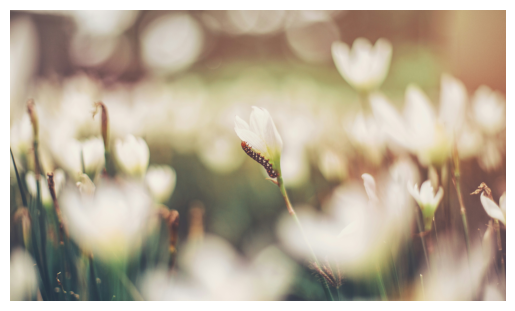

In [14]:
import matplotlib.pyplot as plt
import requests
from PIL import Image

# URL of the image
url = d[24000]

# Fetch the image from the URL
response = requests.get(url, stream=True)
image = Image.open(response.raw)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()


In [15]:
df.head()

,photo_image_url,ai_description
0,https://images.unsplash.com/photo-1544918334-2...,a black and white photo of a sand dune
1,https://images.unsplash.com/photo-1549231634-c...,selective focus photography of petaled flower
2,https://images.unsplash.com/photo-1550551234-2...,brown sand
3,https://images.unsplash.com/photo-156587078342...,man jumping in desert at daytime
4,https://images.unsplash.com/photo-159048680389...,body of water during sunset


## CLIP


In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from transformers import AutoTokenizer, AutoModel
from io import BytesIO
import io
Image.MAX_IMAGE_PIXELS = None
import PIL

In [ ]:
class CustomDataset(Dataset):
    """
    A custom PyTorch dataset for loading images and text descriptions. 
    
    Images are downloaded from URLs provided in a DataFrame, while text descriptions 
    are tokenized using a pre-trained tokenizer (e.g., BERT). This dataset is useful for 
    multimodal tasks like vision-language modeling or image-captioning.
    """
    def __init__(self, df, transform=None):
        """
        Initializes the dataset.
        """
        self.data = df
        self.transform = transform
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a single data sample from the dataset.
        """
        image_url = self.data.iloc[idx, 0]  
        description = self.data.iloc[idx, 1]  

        try:
            response = requests.get(image_url, stream=True)
            response.raise_for_status() 
            image = Image.open(io.BytesIO(response.content)).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except (requests.exceptions.RequestException, PIL.UnidentifiedImageError, OSError) as e:
            print(f"Error loading image from {image_url}: {e}")
            image = Image.new("RGB", (224, 224), (0, 0, 0))  
            if self.transform:
                image = self.transform(image)

        tokens = self.tokenizer(
            description, return_tensors="pt", truncation=True, padding="max_length", max_length=128
        )
        tokens = {key: val.squeeze(0) for key, val in tokens.items()}  

        return image, tokens

In [ ]:
class CLIPModel(nn.Module):
    """
    A CLIP-like model for learning joint representations of images and text.

    This model utilizes a pre-trained ResNet-50 for the image encoder and a pre-trained 
    BERT-based model for the text encoder. Both encoders are then projected into a shared 
    512-dimensional space, where the image and text features can be compared for tasks 
    like image-text matching.
    """
    def __init__(self):
        """
        Initializes the CLIP model by setting up the image encoder (ResNet-50),
        text encoder (BERT), and necessary projection and normalization layers.

        This method prepares all components required for forward pass and feature extraction.
        """
        super(CLIPModel, self).__init__()

        self.image_encoder = models.resnet50(pretrained=True)
        self.image_encoder.fc = nn.Linear(self.image_encoder.fc.in_features, 512)

        self.text_encoder = AutoModel.from_pretrained("bert-base-uncased")
        self.text_projection = nn.Linear(768, 512)

        self.image_normalizer = nn.LayerNorm(512)
        self.text_normalizer = nn.LayerNorm(512)

    def forward(self, images, text_inputs):
        """
        Forward pass to extract features from both images and text using BERT and ResNet.
        """
        image_features = self.image_encoder(images)
        image_features = self.image_normalizer(image_features)

        text_outputs = self.text_encoder(**text_inputs)
        text_features = text_outputs.last_hidden_state[:, 0, :]  
        text_features = self.text_projection(text_features)
        text_features = self.text_normalizer(text_features)

        return image_features, text_features

## Training

In [ ]:
def train_model(model, dataloader, optimizer, criterion, device, num_epochs=10):
    """
    Trains the CLIP model using contrastive loss for a specified number of epochs.

    This function trains a model to learn image-text joint representations. It uses a 
    contrastive loss approach where image and text features are compared to each other 
    by calculating their similarity. The model is updated via backpropagation to minimize 
    the contrastive loss.
    """
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (images, tokens) in enumerate(dataloader):
            images = images.to(device)
            tokens = {k: v.to(device) for k, v in tokens.items()}

            optimizer.zero_grad()

            image_features, text_features = model(images, tokens)

            logits = torch.matmul(image_features, text_features.T)
            labels = torch.arange(images.size(0)).to(device)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {total_loss/len(dataloader):.4f}")

    return model

In [ ]:
import requests
import pandas as pd

if __name__ == "__main__":

    data_csv = df  
    batch_size = 64
    num_epochs = 10
    learning_rate = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load dataset
    dataset = CustomDataset(data_csv, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize CLIP model
    model = CLIPModel()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    trained_model = train_model(model, dataloader, optimizer, criterion, device, num_epochs)

    # Save the model
    model_save_path = "clip_model.pth"
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Step [10/319], Loss: 15.1212
Error loading image from https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1675826638532-09d5c136dd7a: 404 Client Error: Not Found for url: https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1675826638532-09d5c136dd7a
Epoch [1/10], Step [20/319], Loss: 9.2352
Error loading image from https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1676667573119-40081df5d920: 404 Client Error: Not Found for url: https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1676667573119-40081df5d920
Epoch [1/10], Step [30/319], Loss: 7.0264
Epoch [1/10], Step [40/319], Loss: 5.7729
Error loading image from https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1669842336797-4dfc03afa025: 404 Client Error: Not Found for url: https://images.unsplash.com/unsplash-premium-photos-production/premium_photo-1669842336797-4dfc03afa025
Error loading imag

## Saving the Model

In [ ]:
# Save the model
model_save_path = "clip_model.pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

NameError: name 'trained_model' is not defined

## Evaluating the Model

In [ ]:
import torch.nn.functional as F

def evaluate_model(model, dataloader, device, top_k=1):
    """
    Evaluates the model's performance on a given dataset using image-to-text and text-to-image similarity.

    This function calculates the accuracy of the model in two tasks:
    1. Image-to-Text: Given an image, we check if the correct text description is among the top-k similar descriptions.
    2. Text-to-Image: Given a text description, we check if the correct image is among the top-k similar images.

    The model's output features (image and text) are normalized, and the similarity between image and text features
    is calculated using cosine similarity.
    """
    model.eval()
    correct_image_to_text = 0
    correct_text_to_image = 0
    total_samples = 0

    with torch.no_grad():
        for images, tokens in dataloader:
            images = images.to(device)
            tokens = {k: v.to(device) for k, v in tokens.items()}

            image_features, text_features = model(images, tokens)

            image_features = F.normalize(image_features, dim=1)
            text_features = F.normalize(text_features, dim=1)

            similarity_matrix = torch.matmul(image_features, text_features.T)

            image_to_text_rankings = similarity_matrix.argsort(descending=True, dim=1)
            for i in range(images.size(0)):
                if i in image_to_text_rankings[i, :top_k]:
                    correct_image_to_text += 1

            text_to_image_rankings = similarity_matrix.argsort(descending=True, dim=0)
            for i in range(images.size(0)):
                if i in text_to_image_rankings[:, i][:top_k]:
                    correct_text_to_image += 1

            total_samples += images.size(0)

    image_to_text_accuracy = correct_image_to_text / total_samples * 100
    text_to_image_accuracy = correct_text_to_image / total_samples * 100

    print(f"Image-to-Text Accuracy: {image_to_text_accuracy:.2f}%")
    print(f"Text-to-Image Accuracy: {text_to_image_accuracy:.2f}%")
    return image_to_text_accuracy, text_to_image_accuracy


In [ ]:
# Evaluate the model
image_to_text_acc, text_to_image_acc = evaluate_model(trained_model, dataloader, device, top_k=1)